In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)

# Load data into dataframes and explore data structure
dataframe_raw = pd.read_csv('DF_Raw_Data.csv')
dataframe_stdev = pd.read_csv('DF_Rolling_Stdev.csv')
dataframe_raw.columns

Index(['Data Source', 'TIMEFRAME (DD/MM/YYYY)', 'Volumetric Flow Meter 1',
       'Volumetric Flow Meter 2', 'Pump Speed (RPM)', 'Pump Torque ',
       'Ambient Temperature', 'Horse Power', 'Pump Efficiency',
       'PUMP FAILURE (1 or 0)'],
      dtype='object')

---------------------------------------------------------------------------

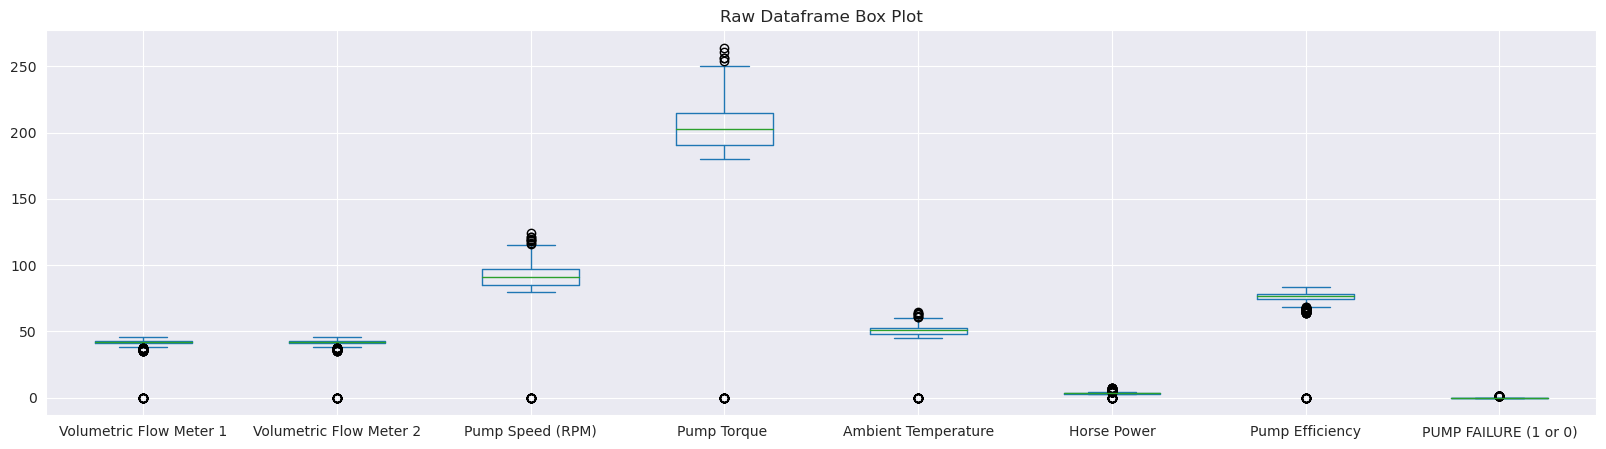

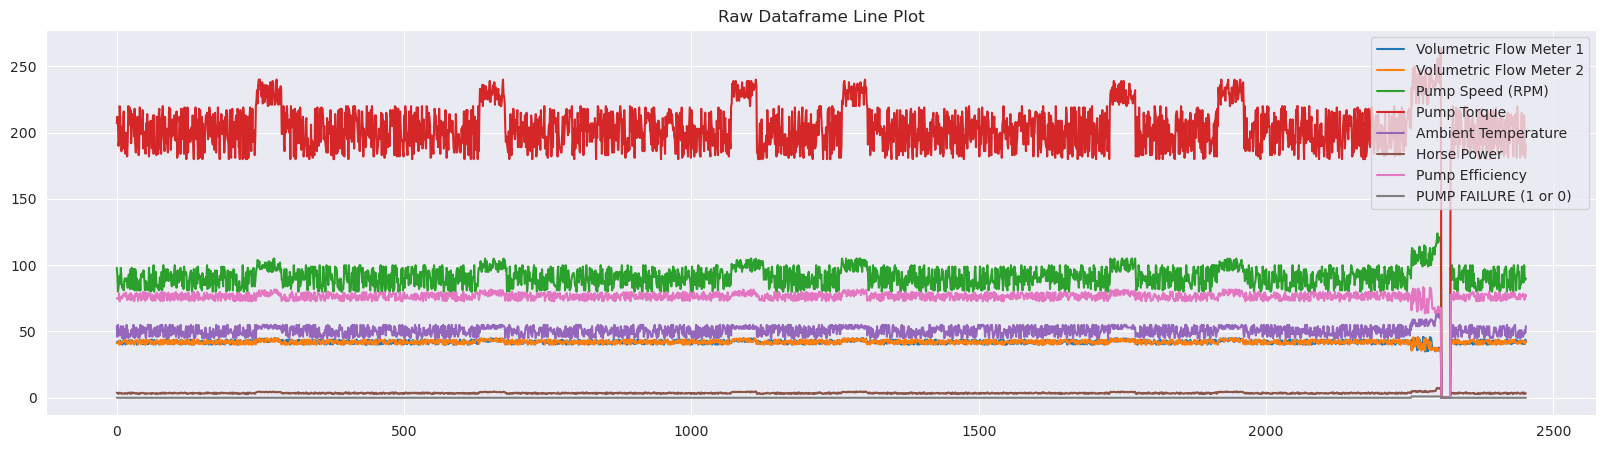

In [2]:
# Create a box and line plot to get a general idea of data spread
dataframe_raw.plot(kind='box').set_title('Raw Dataframe Box Plot')
dataframe_raw.plot(kind='line').set_title('Raw Dataframe Line Plot')

plt.show()

Pump Torque seems to have the most outliers than any other variable
Horse Power has the least outliers (apart from Pump Failure)
There seems to be some correlation at the time of a Pump Failure

---------------------------------------------------------------------------

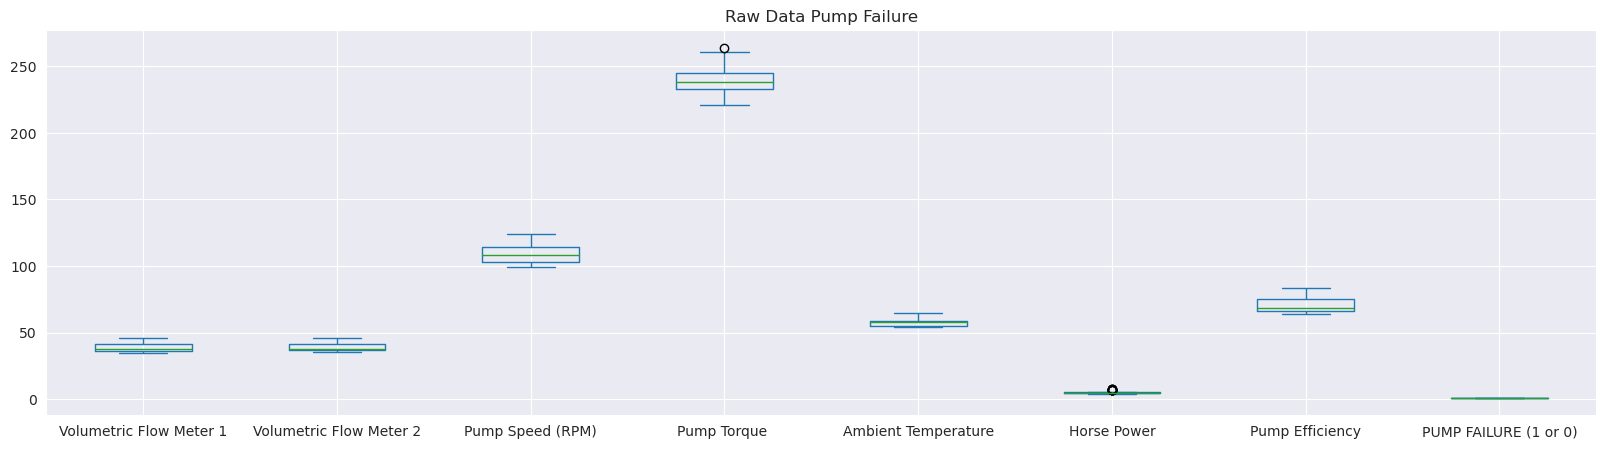

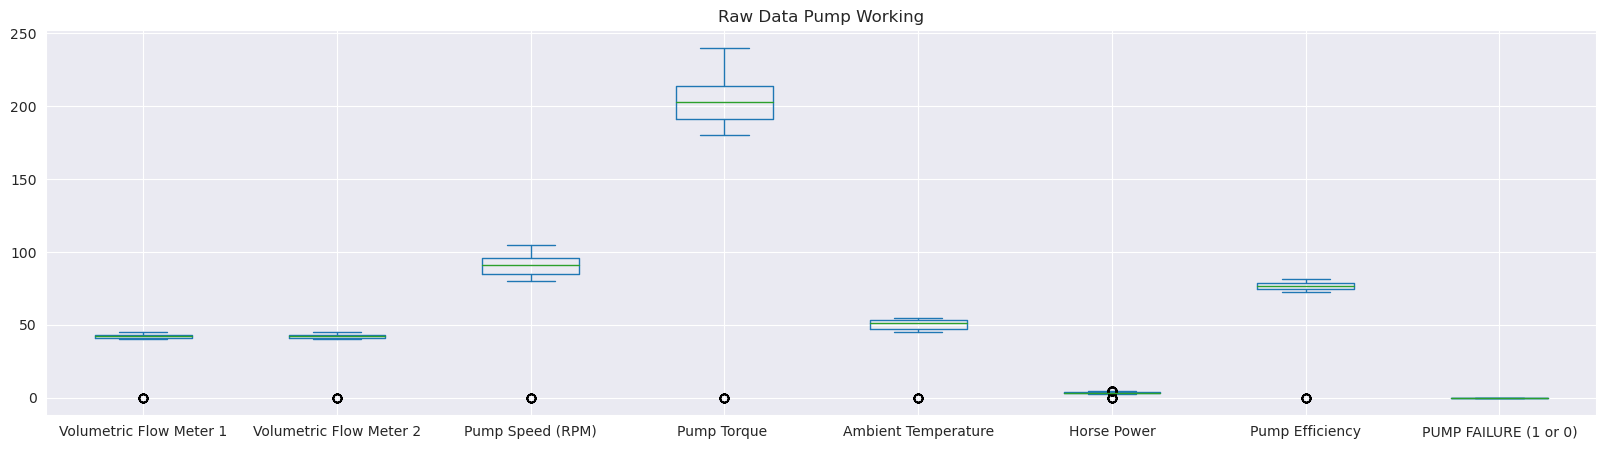

In [4]:
# Create graphs while pump is/isn't working
fail = dataframe_raw['PUMP FAILURE (1 or 0)'] == 1
good = dataframe_raw['PUMP FAILURE (1 or 0)'] == 0

fail_raw = dataframe_raw[fail]
good_raw = dataframe_raw[good]

fail_raw.plot(kind='box').set_title('Raw Data Pump Failure')
good_raw.plot(kind='box').set_title('Raw Data Pump Working')

plt.show()

Visually, the size of the interquartile range (IQR) for most of the sensors are larger.
This could indicates a larger varience.
Pump Torque looks to have the most change while Ambient Temperature has the least

---------------------------------------------------------------------------

In [6]:
# Create Quartiles to filter outliers
q1 = dataframe_raw.quantile(.25, axis=0, numeric_only=True)
q2 = dataframe_raw.quantile(.5, axis=0, numeric_only=True)
q3 = dataframe_raw.quantile(.75, axis=0, numeric_only=True)
iqr = q3-q1
lower_range = q1-1.5*iqr
upper_range = q3 + 1.5*iqr

# Separate into numerical and categorical data
# Categorical data isn't used in this case but can be relevant in other cases
num_raw = dataframe_raw.select_dtypes(include=['number'])
cat_raw = dataframe_raw.select_dtypes(exclude=['number'])

# Identify Outliers
outliers = num_raw[((num_raw < lower_range)|(num_raw > upper_range)).any(axis=1)]

count_not_outliers = len(dataframe_raw.index)
count_of_outliers = len(outliers.index)
percent_outliers = str(round((count_of_outliers/count_not_outliers)*100,2)) + '%'

print(f'Total count: {count_not_outliers}\nOutlier count: {count_of_outliers}\nPercent outliers: {percent_outliers}')

Total count: 2453
Outlier count: 95
Percent outliers: 3.87%


Since less than 4% of the data contributed to outliers, this is a good indicator for potential correlation.
If the outlier concentration was higher, we would see significant changes in the graphs and analysis

---------------------------------------------------------------------------

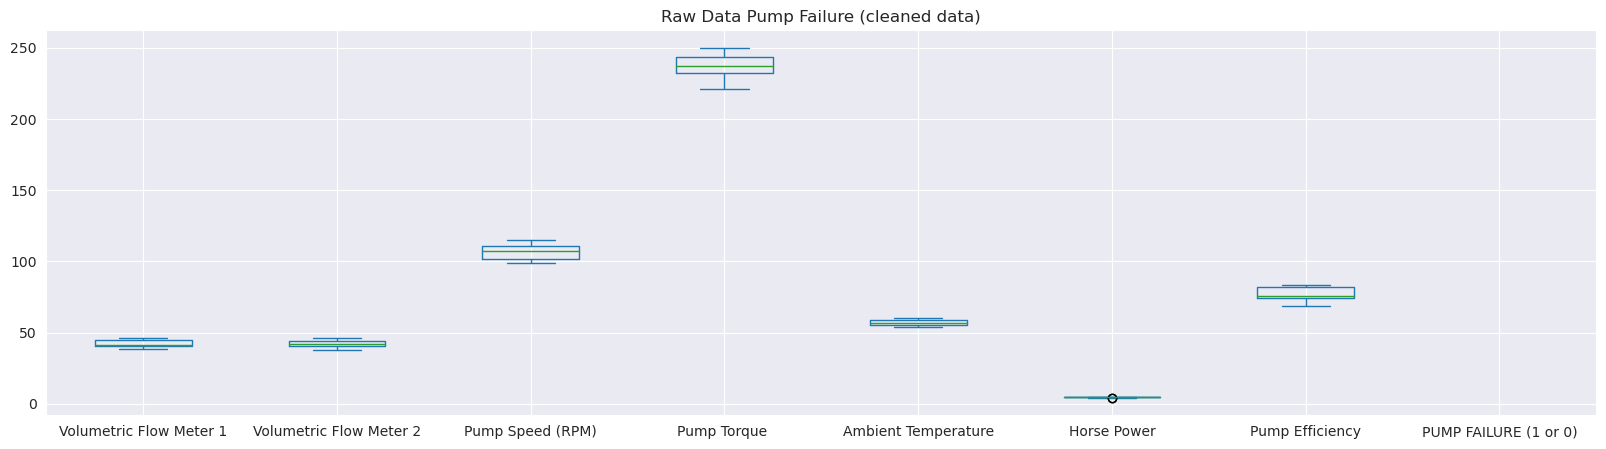

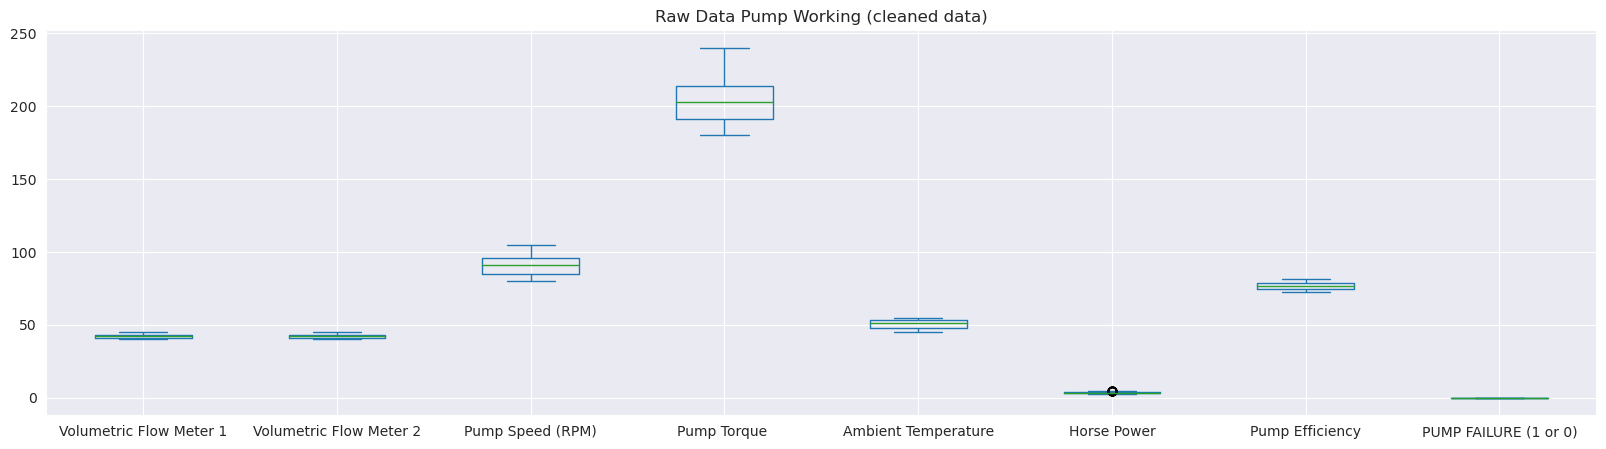

In [7]:
# Remove all outliers to look at cleaned data for differences
no_outliers = dataframe_raw[~((num_raw < lower_range)|(num_raw > upper_range))]

fail_clean_raw = no_outliers[fail]
fail_clean_raw.plot(kind='box').set_title('Raw Data Pump Failure (cleaned data)')
good_clean_raw = no_outliers[good]
good_clean_raw.plot(kind='box').set_title('Raw Data Pump Working (cleaned data)')
plt.show()

---

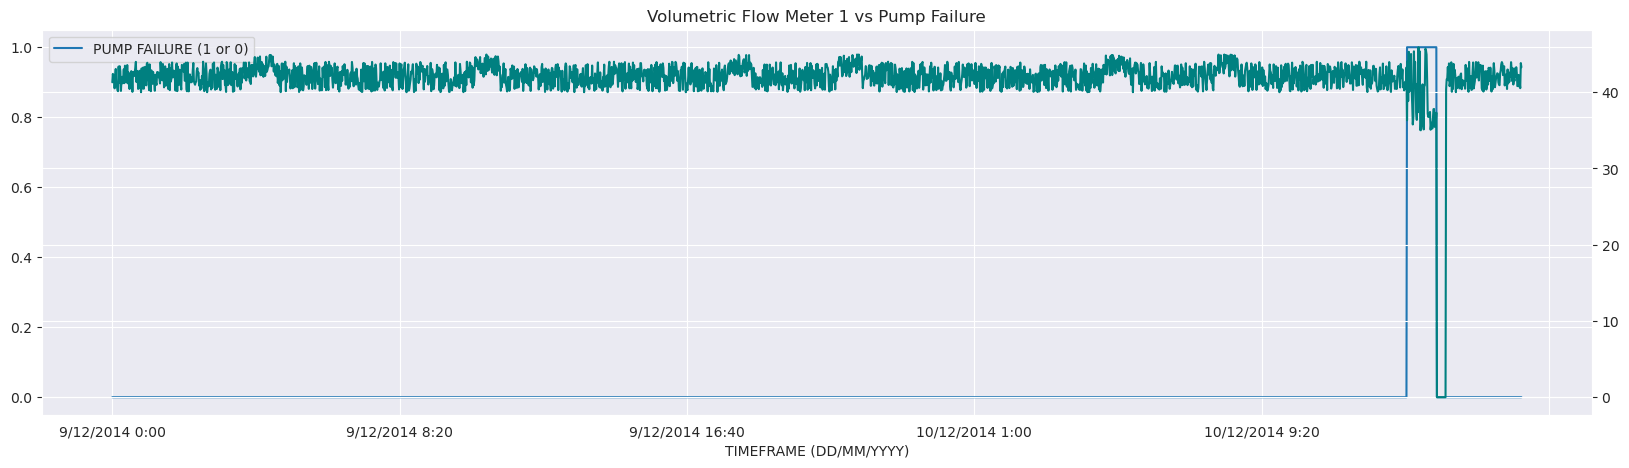

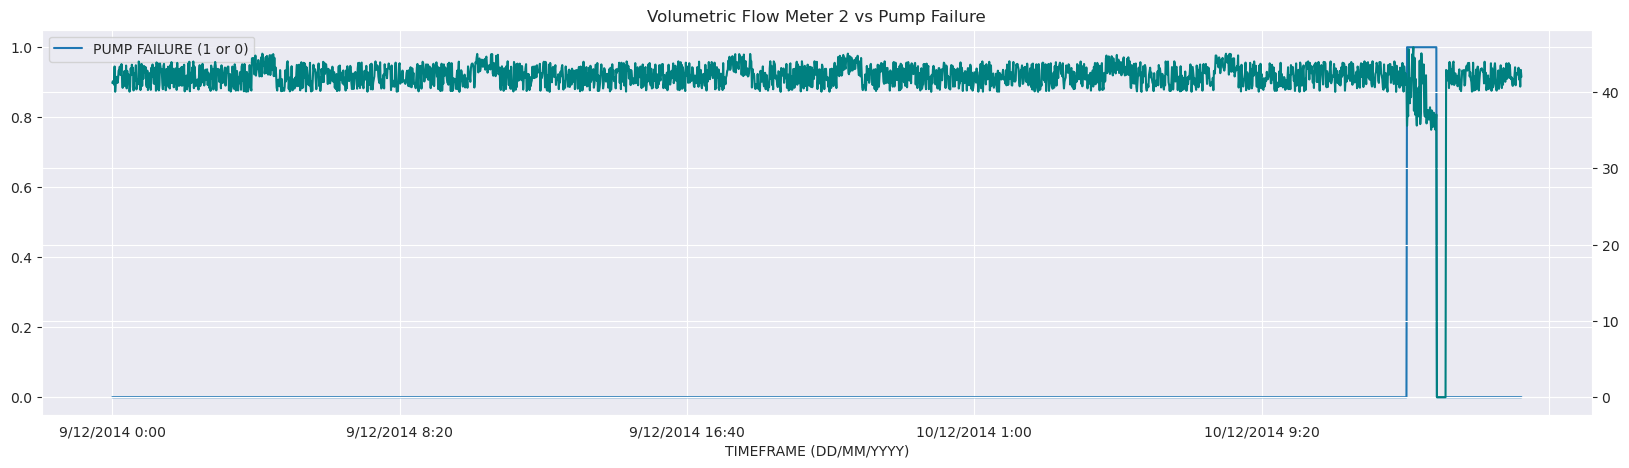

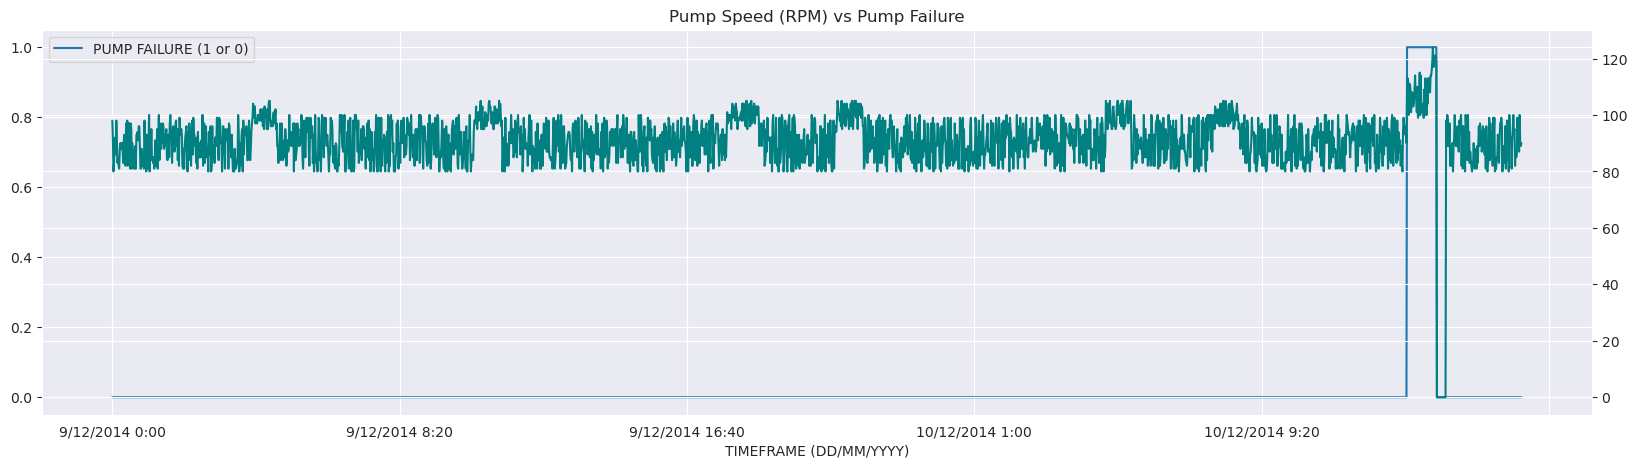

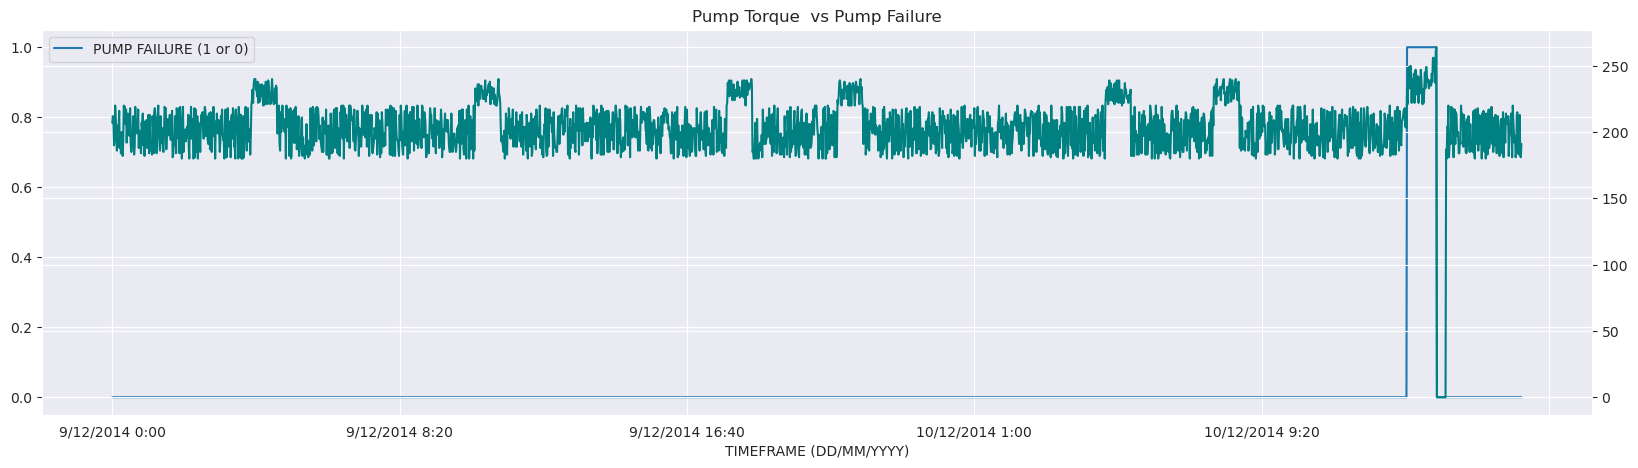

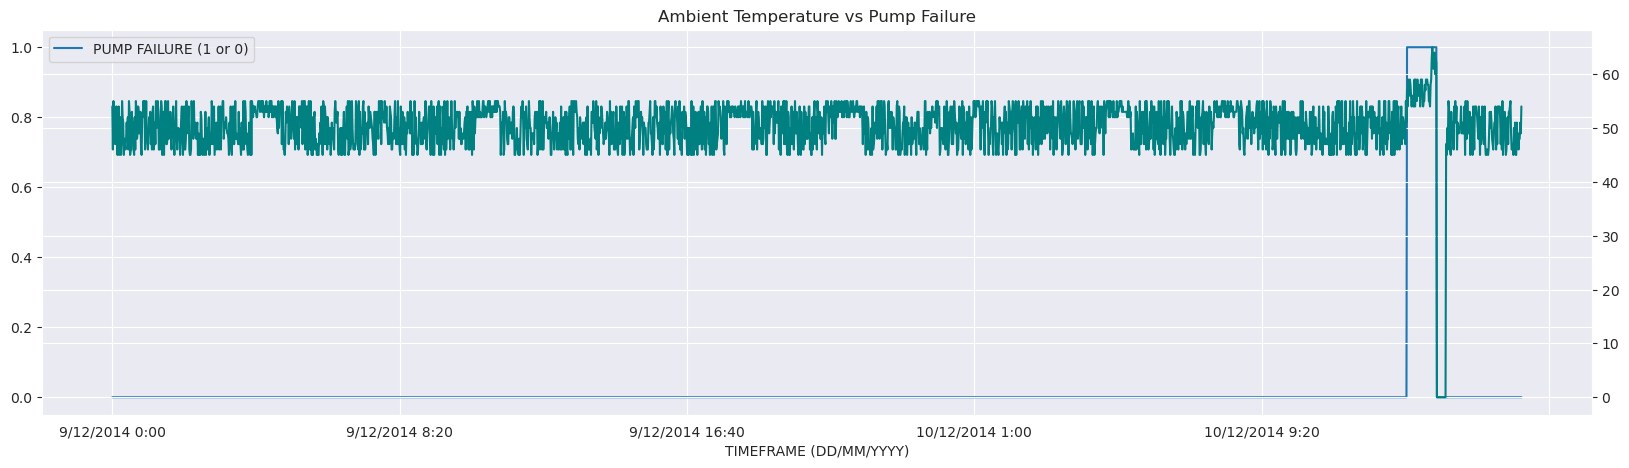

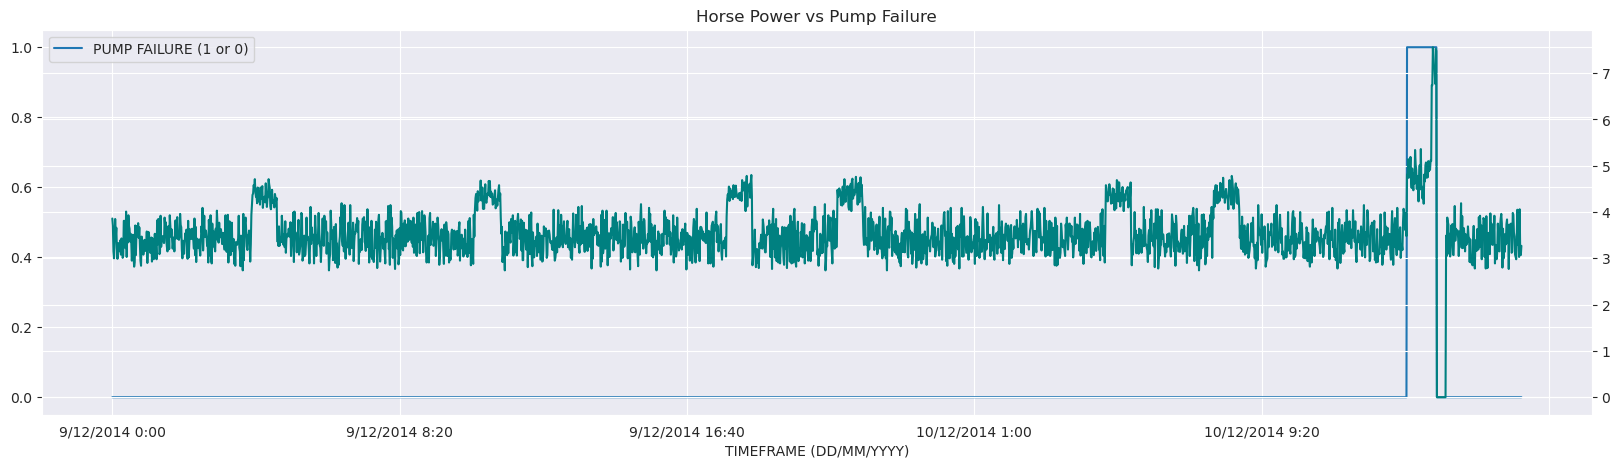

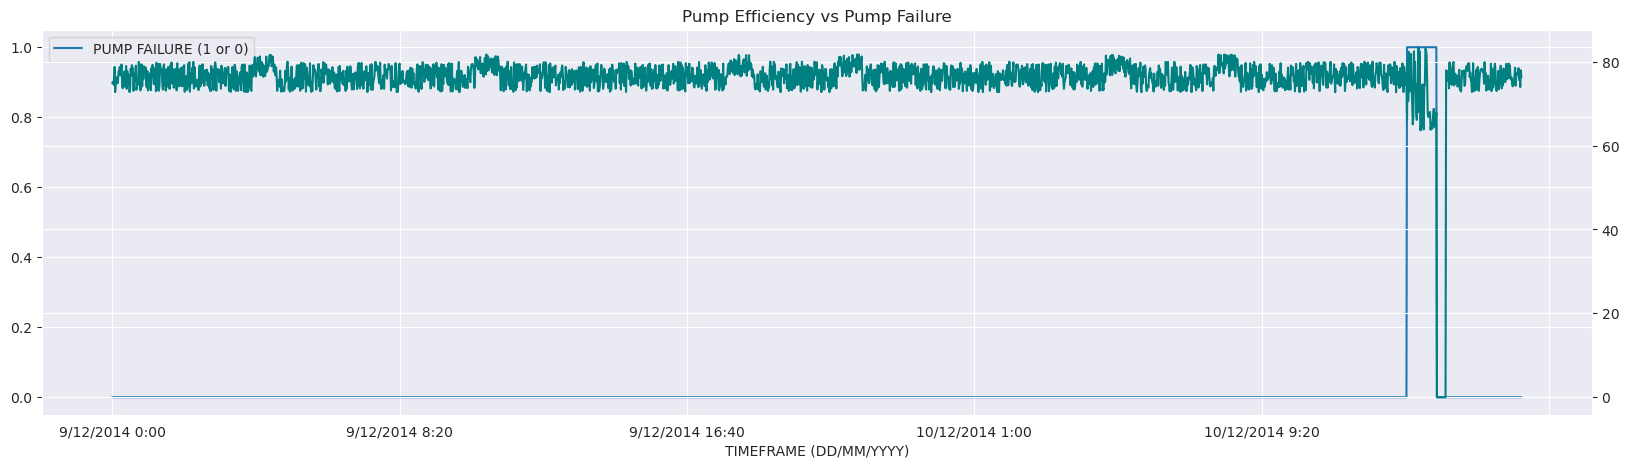

In [85]:
# Graph each variable along with Pump Failure to see if there is correlation
list_of_variables = ['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2', \
                     'Pump Speed (RPM)', 'Pump Torque ', 'Ambient Temperature', \
                     'Horse Power',  'Pump Efficiency']


for item in list_of_variables:
    first_axis = dataframe_raw.plot(x='TIMEFRAME (DD/MM/YYYY)',y='PUMP FAILURE (1 or 0)')
    second_axis = first_axis.twinx()
    second_axis.plot(dataframe_raw[item],color='teal')
    plt.title(f'{item} vs Pump Failure')
    plt.show()



Horse Power seems to have a stronger reaction to Pump Failure than others, however most of the variables
tend to show some sort of extreme behavior during a failure as well.

---

In [202]:
# Create a 30 minute rolling Standard Deviation dataframe

# Exclude columns with non-numeric data
numeric_df = dataframe_raw.select_dtypes(exclude='object')


# Compute rolling standard deviation for the raw data
#computed_rolling_std = numeric_df.rolling(window=30).std()
#computed_rolling_std.dropna(inplace=True)

# Select all numeric columns except for 'exclude_column'
selected_columns = dataframe_raw.select_dtypes(include=[np.number]).drop(columns='PUMP FAILURE (1 or 0)').columns

# Calculate the rolling standard deviation on the selected columns
computed_rolling_std = dataframe_raw[selected_columns].rolling(window=15).std()

# Drop all null values (from rolling calculation) and shift x axis for Pump Failure to line up accurately
length_before = len(computed_rolling_std)
computed_rolling_std.dropna(inplace=True)
length_after = len(computed_rolling_std)
shift = length_before - length_after

# Adding 'PUMP FAILURE (1 or 0)' column to computed_rolling_std and shift
computed_rolling_std['PUMP FAILURE (1 or 0)'] = dataframe_raw['PUMP FAILURE (1 or 0)']
cols_to_shift = ['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2', \
                 'Pump Speed (RPM)', 'Pump Torque ', 'Ambient Temperature', \
                 'Horse Power',  'Pump Efficiency']
for col in cols_to_shift:
    computed_rolling_std[col] = computed_rolling_std[col].shift(shift)
# Assuming the original DataFrame is called dataframe_raw
# Extract the time column from the original dataframe
time_column = dataframe_raw['TIMEFRAME (DD/MM/YYYY)']

# Set this column as the index of the computed_rolling_std DataFrame
computed_rolling_std['TIME'] = time_column
computed_rolling_std.set_index('TIME', inplace=True)

# Now you can proceed with your plotting code
print(computed_rolling_std.index)
print(computed_rolling_std.columns)

Index(['9/12/2014 0:14', '9/12/2014 0:15', '9/12/2014 0:16', '9/12/2014 0:17',
       '9/12/2014 0:18', '9/12/2014 0:19', '9/12/2014 0:20', '9/12/2014 0:21',
       '9/12/2014 0:22', '9/12/2014 0:23',
       ...
       '10/12/2014 16:43', '10/12/2014 16:44', '10/12/2014 16:45',
       '10/12/2014 16:46', '10/12/2014 16:47', '10/12/2014 16:48',
       '10/12/2014 16:49', '10/12/2014 16:50', '10/12/2014 16:51',
       '10/12/2014 16:52'],
      dtype='object', name='TIME', length=2439)
Index(['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2',
       'Pump Speed (RPM)', 'Pump Torque ', 'Ambient Temperature',
       'Horse Power', 'Pump Efficiency', 'PUMP FAILURE (1 or 0)'],
      dtype='object')


Index(['9/12/2014 0:14', '9/12/2014 0:15', '9/12/2014 0:16', '9/12/2014 0:17',
       '9/12/2014 0:18', '9/12/2014 0:19', '9/12/2014 0:20', '9/12/2014 0:21',
       '9/12/2014 0:22', '9/12/2014 0:23',
       ...
       '10/12/2014 16:43', '10/12/2014 16:44', '10/12/2014 16:45',
       '10/12/2014 16:46', '10/12/2014 16:47', '10/12/2014 16:48',
       '10/12/2014 16:49', '10/12/2014 16:50', '10/12/2014 16:51',
       '10/12/2014 16:52'],
      dtype='object', name='TIME', length=2439)
Index(['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2',
       'Pump Speed (RPM)', 'Pump Torque ', 'Ambient Temperature',
       'Horse Power', 'Pump Efficiency', 'PUMP FAILURE (1 or 0)'],
      dtype='object')


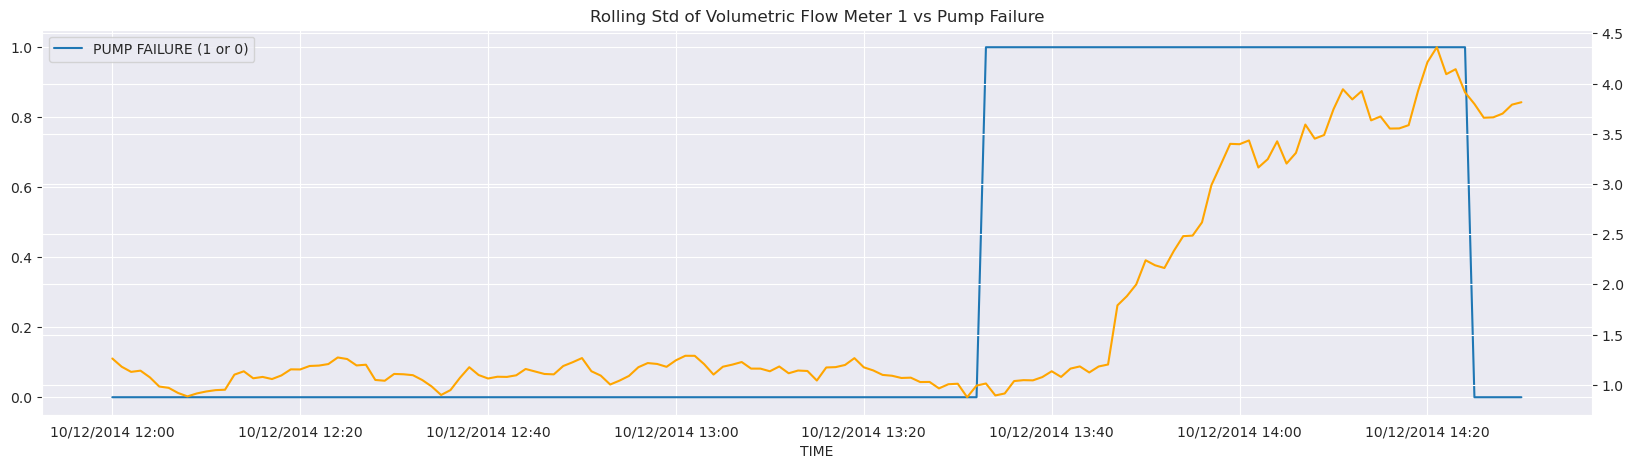

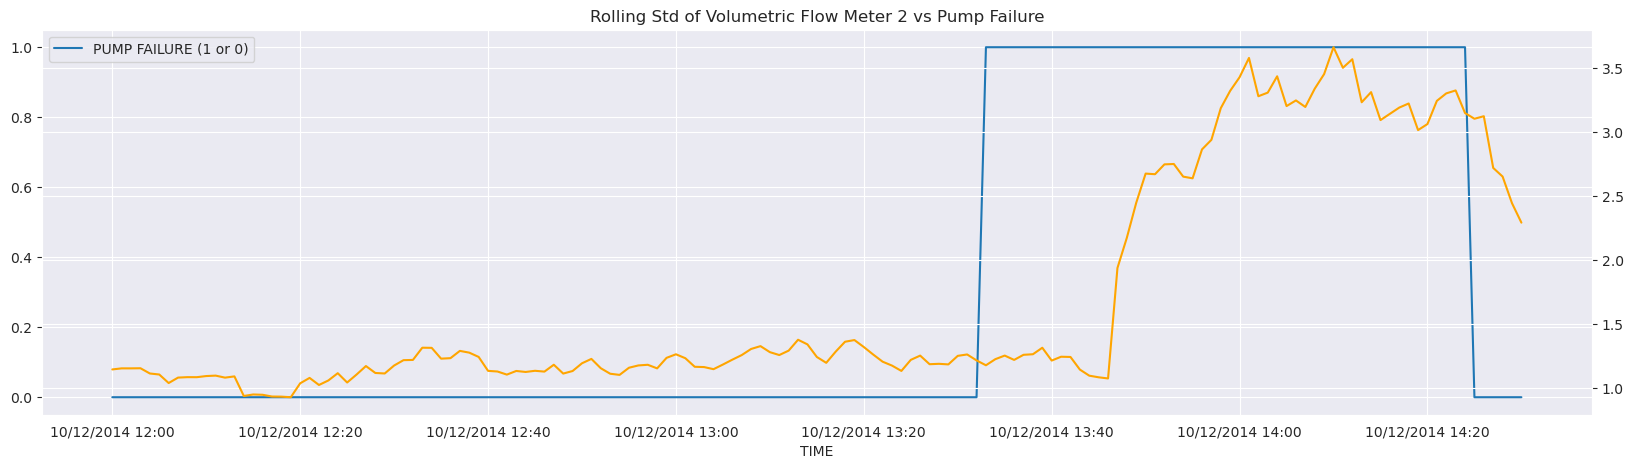

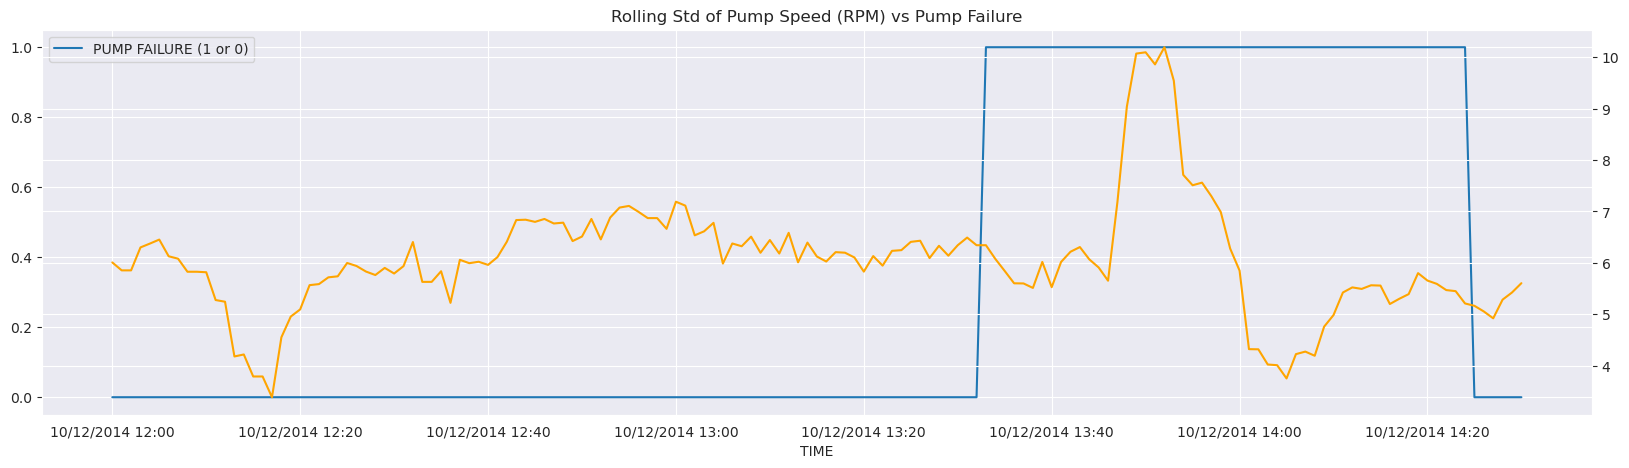

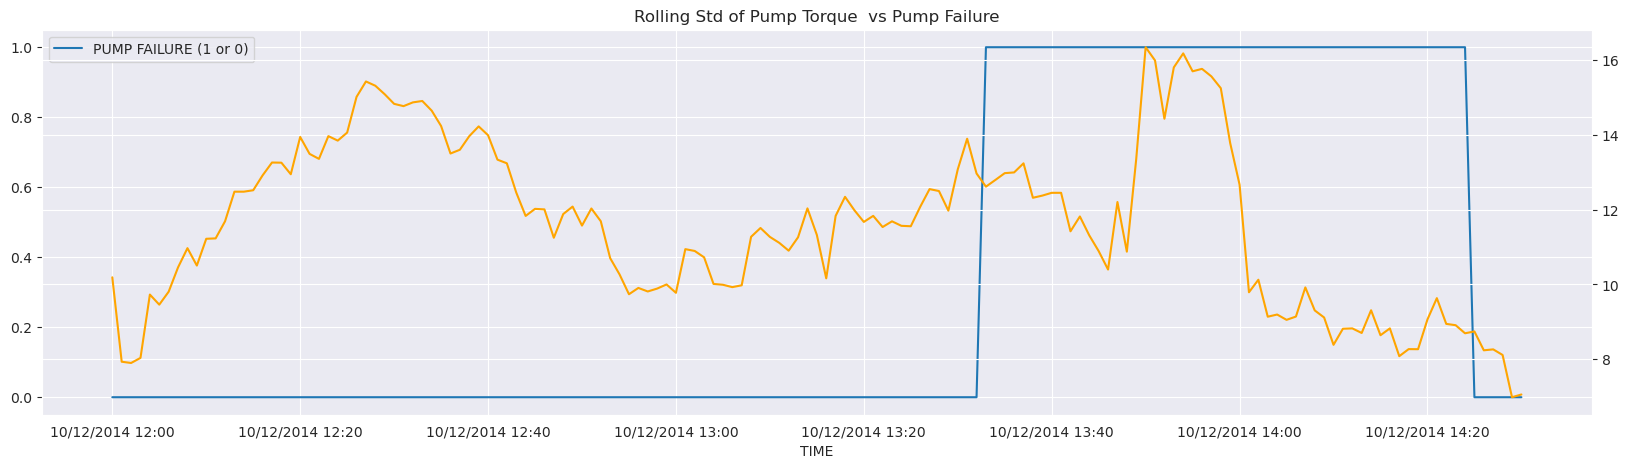

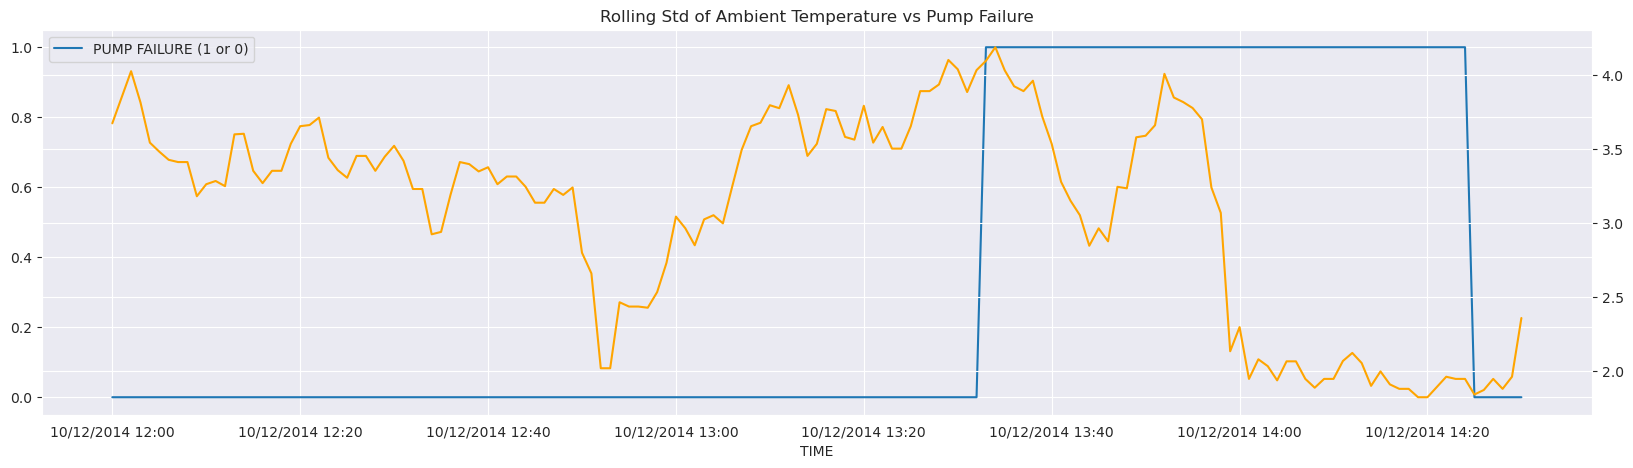

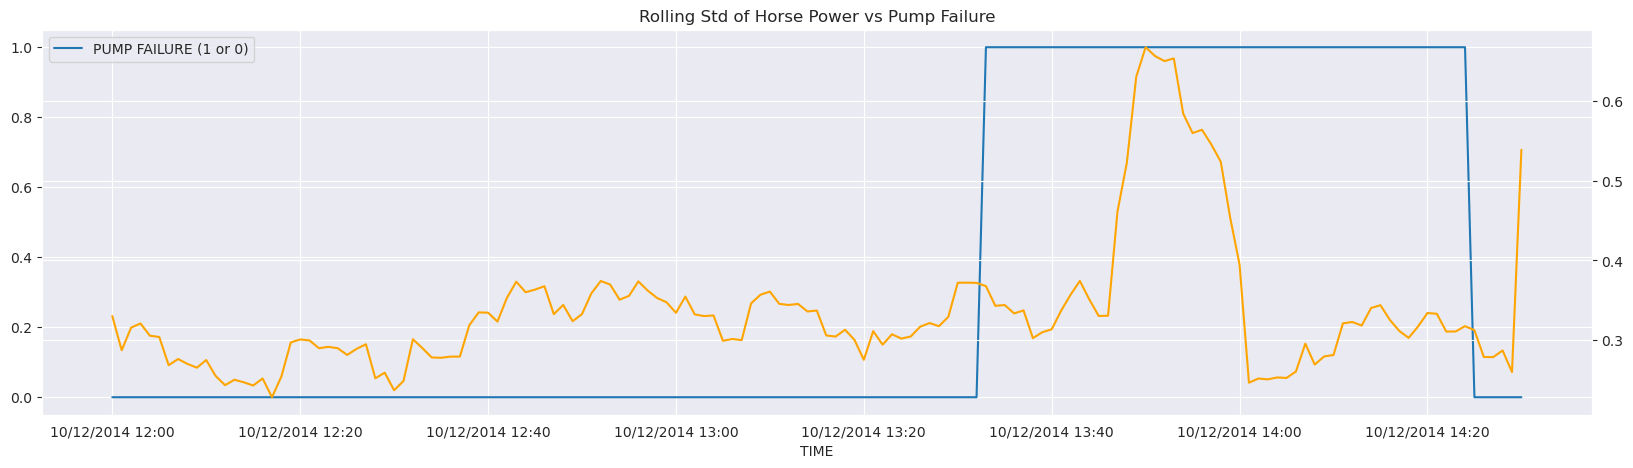

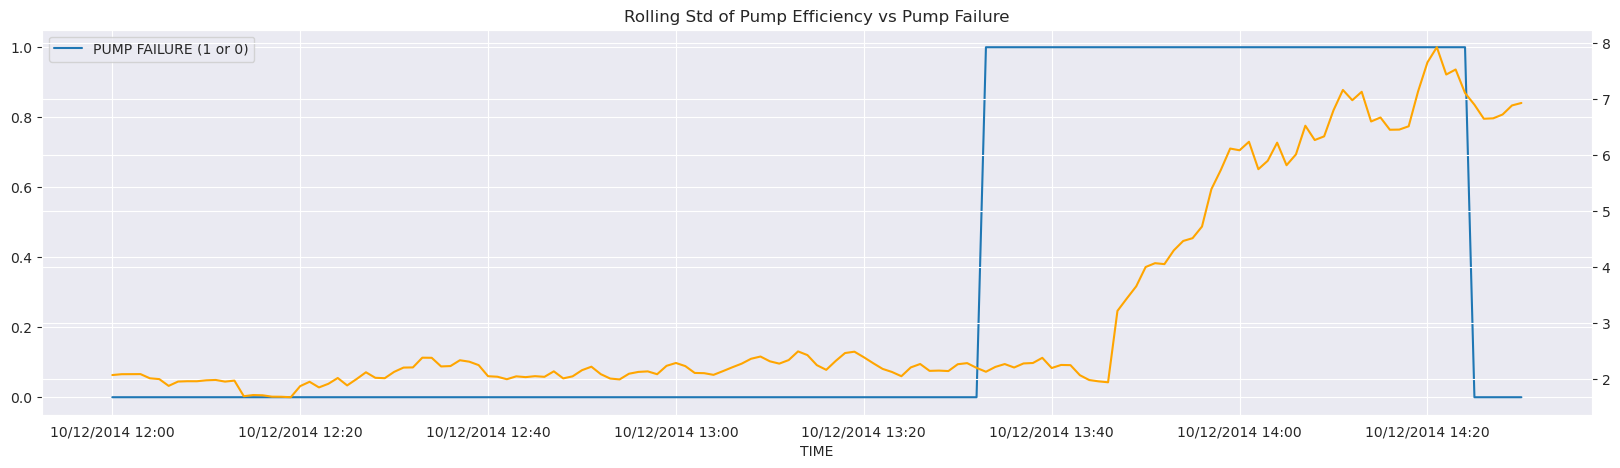

In [203]:
print(computed_rolling_std.index)
print(computed_rolling_std.columns)

# Assuming your computed rolling standard deviation DataFrame is named computed_rolling_std
# Set index
#computed_rolling_std.set_index('TIMEFRAME (DD/MM/YYYY)', inplace=True)
list_of_variables = ['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2',
                     'Pump Speed (RPM)', 'Pump Torque ', 'Ambient Temperature',
                     'Horse Power',  'Pump Efficiency']

# Filter by the desired time range
time_filtered = computed_rolling_std[(computed_rolling_std.index >= "10/12/2014 12:00") & (computed_rolling_std.index <= "10/12/2014 14:30")]

# Create plots
for item in list_of_variables:
    first_axis = time_filtered.plot(y='PUMP FAILURE (1 or 0)')
    first_axis.xaxis.set_major_locator(plt.MaxNLocator(10))
    second_axis = first_axis.twinx()
    second_axis.plot(time_filtered[item], color='orange')
    second_axis.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.title(f'Rolling Std of {item} vs Pump Failure')
    plt.show()


---

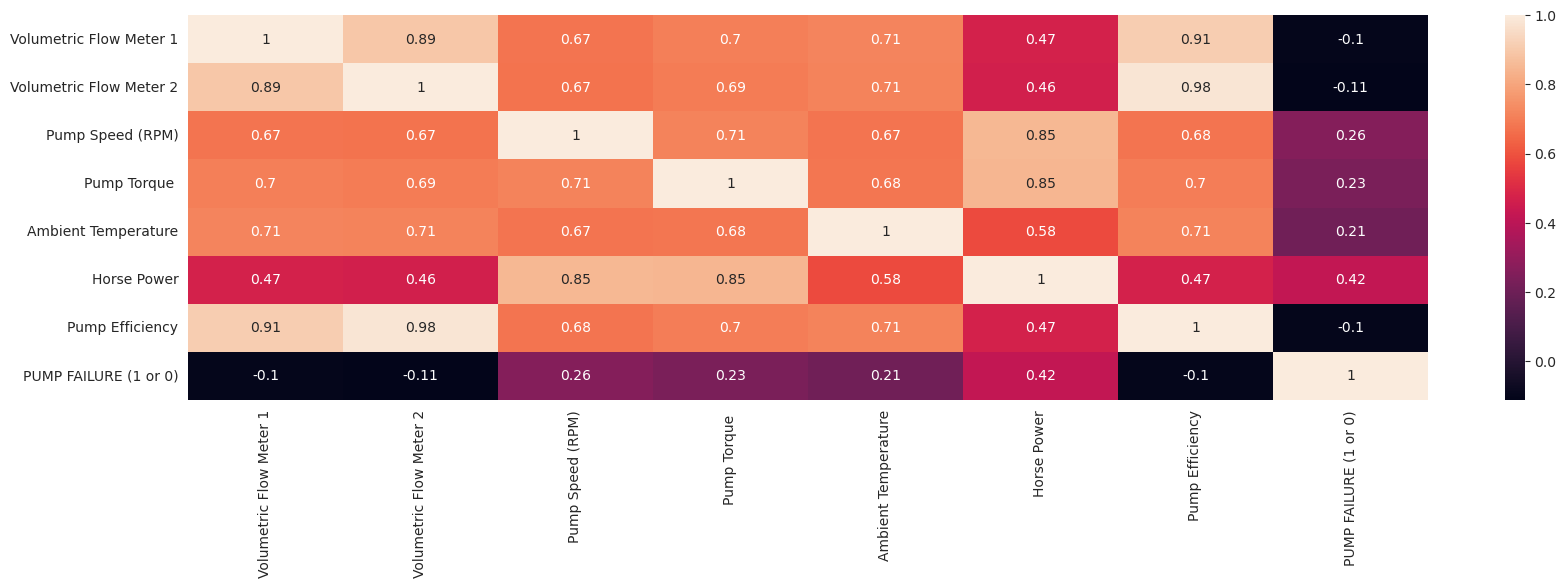

In [132]:
# Create a correlation coefficient heatmap using the numerical data columns
num_raw = dataframe_raw[['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2', 'Pump Speed (RPM)', 'Pump Torque ',  'Ambient Temperature', 'Horse Power','Pump Efficiency', 'PUMP FAILURE (1 or 0)']]
corr = num_raw.corr(numeric_only=True)

sns.heatmap(corr,annot=True)
plt.show()

Horse Power has the strongest correlation with Pump Failure

---

                              OLS Regression Results                             
Dep. Variable:     PUMP FAILURE (1 or 0)   R-squared:                       0.362
Model:                               OLS   Adj. R-squared:                  0.360
Method:                    Least Squares   F-statistic:                     197.9
Date:                   Thu, 17 Aug 2023   Prob (F-statistic):          5.58e-233
Time:                           18:50:41   Log-Likelihood:                 1823.0
No. Observations:                   2453   AIC:                            -3630.
Df Residuals:                       2445   BIC:                            -3583.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

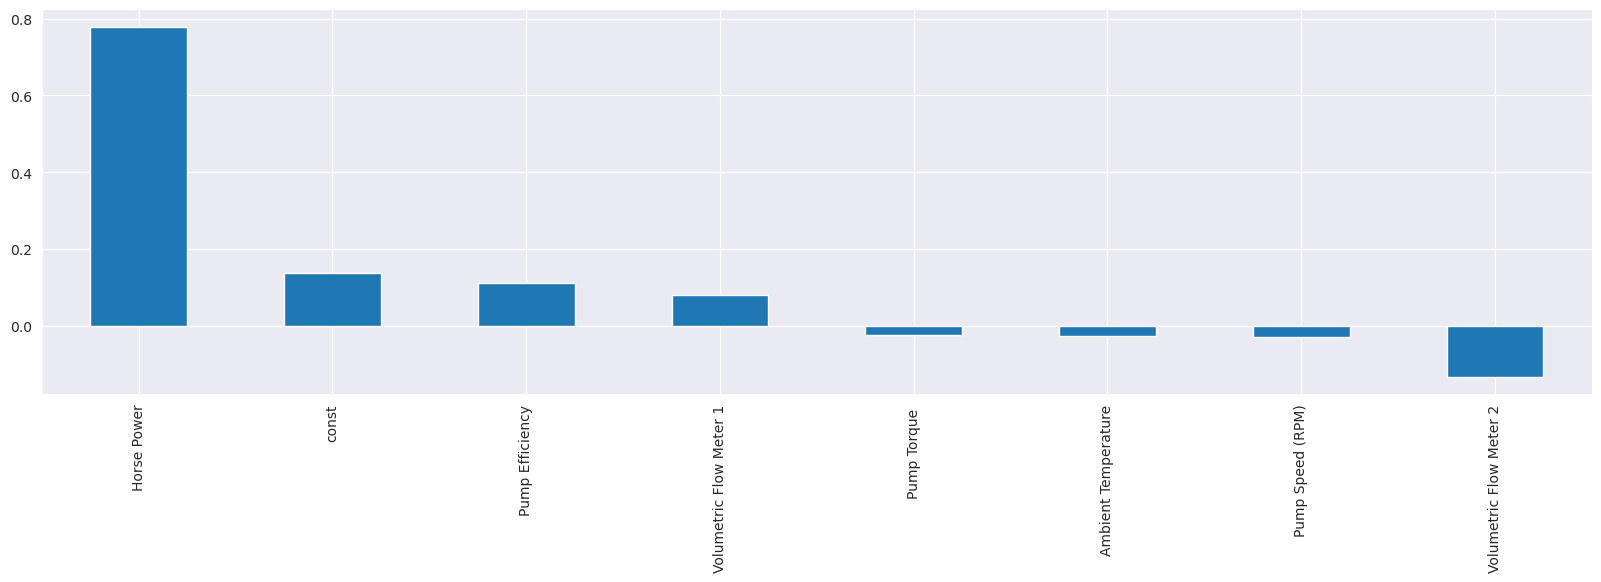

In [209]:
#Dataframe_Raw

independent_variables_raw = dataframe_raw[['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2', \
                                       'Pump Speed (RPM)', 'Pump Torque ',  'Ambient Temperature', \
                                       'Horse Power','Pump Efficiency']]
independent_variables_raw = sm.add_constant(independent_variables_raw)
dependent_variable_raw = dataframe_raw['PUMP FAILURE (1 or 0)']
regression_model_raw = sm.OLS(dependent_variable_raw,independent_variables_raw).fit()




print(regression_model_raw.summary())
regression_model.params.sort_values(ascending=False).plot(kind='bar')
plt.show()

                              OLS Regression Results                             
Dep. Variable:     PUMP FAILURE (1 or 0)   R-squared:                       0.537
Model:                               OLS   Adj. R-squared:                  0.536
Method:                    Least Squares   F-statistic:                     402.8
Date:                   Thu, 17 Aug 2023   Prob (F-statistic):               0.00
Time:                           19:23:37   Log-Likelihood:                 2197.3
No. Observations:                   2439   AIC:                            -4379.
Df Residuals:                       2431   BIC:                            -4332.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

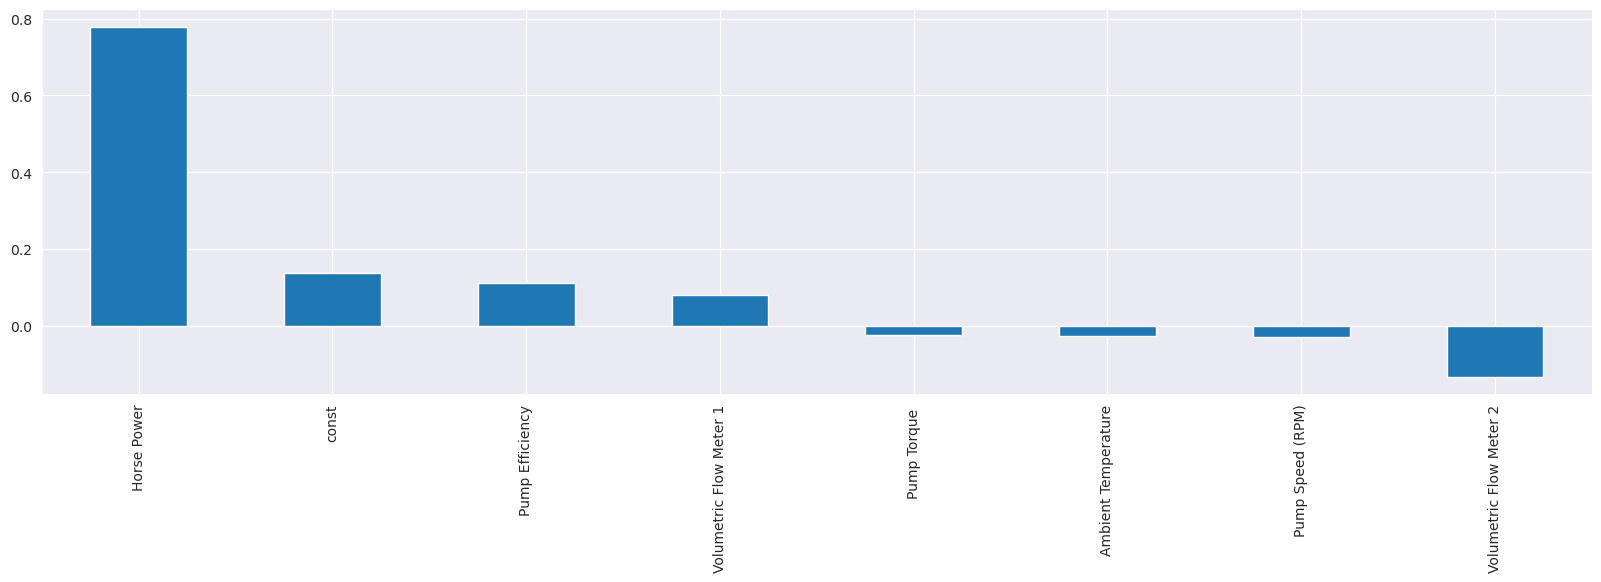

In [222]:
independent_variables = computed_rolling_std[['Volumetric Flow Meter 1', 'Volumetric Flow Meter 2', \
                                       'Pump Speed (RPM)', 'Pump Torque ',  'Ambient Temperature', \
                                       'Horse Power','Pump Efficiency']]
independent_variables = sm.add_constant(independent_variables)
dependent_variable = computed_rolling_std['PUMP FAILURE (1 or 0)']
regression_model = sm.OLS(dependent_variable,independent_variables).fit()




print(regression_model.summary())
regression_model.params.sort_values(ascending=False).plot(kind='bar')
plt.show()

The std model has a higher R value indicating a more accurate model.
An R value of 0.537 suggests a lower possibility of random chance having an effect on the correlation

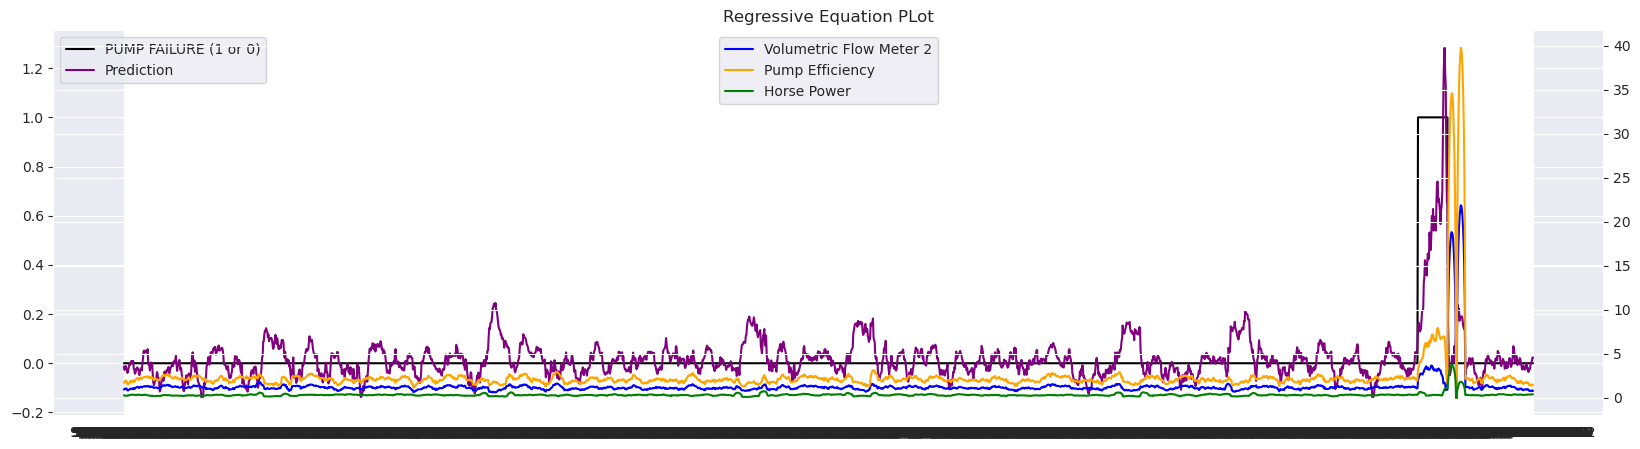

In [221]:
computed_rolling_std['Prediction'] = regression_model.predict(independent_variables)
#computed_rolling_std.set_index('TIMEFRAME (DD/MM/YYYY)')

fig, ax1 = plt.subplots()

ax1.plot(computed_rolling_std['PUMP FAILURE (1 or 0)'], color = 'black')
ax1.plot(computed_rolling_std['Prediction'], color = 'purple')

ax2 = ax1.twinx()
ax2.plot(computed_rolling_std['Volumetric Flow Meter 2'],color='blue')
ax2.plot(computed_rolling_std['Pump Efficiency'],color='orange')
ax2.plot(computed_rolling_std['Horse Power'],color='green')

list1 = ['PUMP FAILURE (1 or 0)','Prediction']
list2 = ['Volumetric Flow Meter 2','Pump Efficiency','Horse Power']
ax1.legend(list1,loc='upper left')
ax2.legend(list2,loc='upper center')

plt.title('Regressive Equation PLot')
plt.show()